# [Weather data and solar radiation](01ReadWeatherData.ipynb)

# [Thermal circuit and state-space representation for a thermal circuit with capacities in every node: simple wall](02SimpleWall.ipynb)

# [Thermal circuit and state-space representation for a thermal circuit with capacities in some nodes: cubic building](03CubeFB.ipynb)

# [Thermal circuits assembling](04AssemblingTC.ipynb)

# [Switch between models: heating & cooling and free-running](05SwitchModels.ipynb)

# Control input: heating & cooling and free-running

Objectives:
- Change the control input during the integration. 
- Switch between models during the integration. 

![thermal_circuit](./figures/03_therm_circ.png)
> Figure 1. Thermal circuit for the cubic building.

In this example, we will consider that the controller is not modeled by the conductance 11 and the temperature source $T_{i,sp}$ but, instead, by the heatflow rate $\dot{Q}_a$, which is added to the indoor air in node 6 (Figure 1). Therefore, the conductance $G_{11} \rightarrow 0$ and the input
$$u_6 = K_p (T_{i,sp} - \theta_i)$$
where:
- $K_p$ is the static gain of the proportional controller;
- $T_{i,sp}$ - indoor temperature setpoint, °C;
- $\theta_i$ - indoor temperature, °C.


In [1]:
import numpy as np
import dm4bem
import tuto

Let's consider a location and time period for simulation of the toy model presented in tutorials 3 `t03CubeFB.ipynb`, 4 `t04AssTC.ipynb` and 5 `t05SwitchModels.ipynb` (Figure 1).

In [2]:
filename = './weather_data/FRA_Lyon.074810_IWEC.epw'

In [3]:
start_date = '2000-07-01 00:00:00'
end_date = '2000-07-03 00:00:00'

## Create the model for free-running

Let's consider that the P-controller is not effective, i.e. $K_p \rightarrow 0$, i.e. the building is in free running (the indoor temperature is free-floating).

In [4]:
Kpf = 1e-3   # no controller Kpf -> 0
TCa = tuto.thermal_circuit(Kpf)
[As, Bs, Cs, Ds] = dm4bem.tc2ss(
    TCa['A'], TCa['G'], TCa['b'], TCa['C'], TCa['f'], TCa['y'])
dtmax = min(-2. / np.linalg.eig(As)[0])
print(f'Maximum time step in free-floating: {dtmax:.2f} s')

Maximum time step in free-floating: 479.08 s


We chose the  [setpoint](https://en.m.wikipedia.org/wiki/Setpoint_(control_system) and the [dead-band](https://en.m.wikipedia.org/wiki/Deadband) for the indoor temperature.

In [5]:
Tisp = 20   # indoor setpoint temperature, °C
Δθ = 5      # temperature deadband, °C

## Simulation in free-running

With the time step for integration,

In [6]:
dt = 360    # time step, s

we obtain the inputs of the model (at simulation time `t` as vector `u` from weather `data`).

In [7]:
t, u, data = tuto.inputs(filename, start_date, end_date, dt,
                         As, Bs, Cs, Ds, Kpf, Tisp)

The results of the simulation are obtained by integration in time.

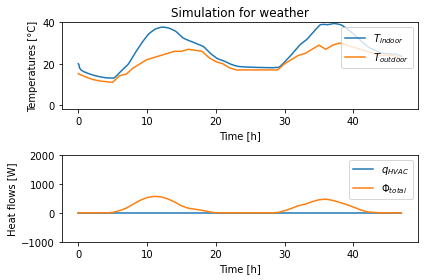

In [8]:
# Initialize temperature vector
θ = np.full([As.shape[0], u.shape[0]], np.inf)
θ[:, 0] = Tisp * np.ones(As.shape[0])

I = np.eye(As.shape[0])

# Simulation in time
for k in range(u.shape[0] - 1):
    θ[:, k + 1] = (I + dt * As) @ θ[:, k]\
        + dt * Bs @ u.iloc[k, :]
# Indoor temperature
y = Cs @ θ + Ds @ u.to_numpy().T
# HVAC heat flow
q_HVAC = Kpf * (data['Ti'] - y[0, :])

# Plot results
tuto.plot_results(t, y.T, θ, q_HVAC, data)

> Figure 2. Simulation in free-floating; the flowrate added to the air is zero, $\dot{Q}_a = 0$.

## Feed-back control

Let's consider that the input 6 models the controller (see Figure 1). If the indoor temperature is in the deadband,
$$T_{i,sp} < \theta_i < T_{i,sp} + \Delta \theta$$
then the command $\dot{Q}_a = 0$; else, the command is proportional to the error,
$$\dot{Q}_a = K_p (T_{i,sp} - \theta_i)$$.

The maximum power of the controller in cooling is limited at 900 W.

Note that the vector of inputs is $u = [u_0, ... , u_7]^T \equiv  [T_o, T_o, T_o, T_{i,sp}, \Phi_o, \Phi_i, \dot{Q}_a, \Phi_a]^T$ (Figure 1). Therefore, $\dot{Q}_a \equiv u_6$.

In [9]:
def sim_HVAC():
    t, u, data = tuto.inputs(filename, start_date, end_date, dt,
                             As, Bs, Cs, Ds, Kpf, Tisp)

    θ = np.full([As.shape[0], u.shape[0]], np.inf)
    θ[:, 0] = Tisp * np.ones(As.shape[0])

    y = np.zeros(u.shape[0])
    y[-1] = Tisp

    for k in range(u.shape[0] - 1):
        if Tisp < y[k - 1] < Tisp + Δθ:
            u.iloc[k, 6] = 0
        else:
            u.iloc[k, 6] = Kpp * (Tisp - y[k - 1])
            u.iloc[k, 6] = max(u.iloc[k, 6], -900)

        θ[:, k + 1] = (I + dt * As) @ θ[:, k]\
            + dt * Bs @ u.iloc[k, :]

        # θ[:, k + 1] = np.linalg.inv(I - dt * As) @\
        #     (θ[:, k] + dt * Bs @ u.iloc[k, :])
        y[k] = Cs @ θ[:, k] + Ds @ u.iloc[k]

    q_HVAC = u.iloc[:, 6].to_numpy()

    tuto.plot_results(t, y, θ, q_HVAC, data)

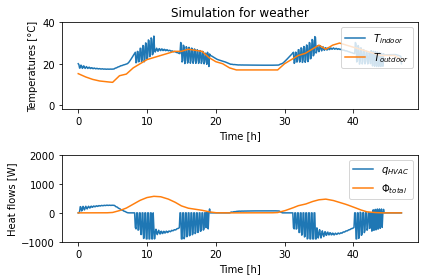

In [10]:
Kpp = 1e2   # perfect controller Kpc -> infinity
dt = 360    # time step, s
sim_HVAC()

> Figure 3. Reuslts of feedback control.

## Stability vs. precision

A control system is precise if the error $\varepsilon = T_{i,sp} - \theta_i$ tends to zero , i.e., the output follows its setpoint. Precision increases with the proportional gain. For the P-controller implemented in the inputs, this increase affects the [stability](https://en.m.wikipedia.org/wiki/Control_theory#Stability) because a [dead-time](https://en.m.wikipedia.org/wiki/Dead_time) equal to the timestep is introduced in [Euler integration](https://en.m.wikipedia.org/wiki/Euler_method). The dead-time changes the limits of stability. If the timestep `dt` is reduced, the simulation is more precise. 

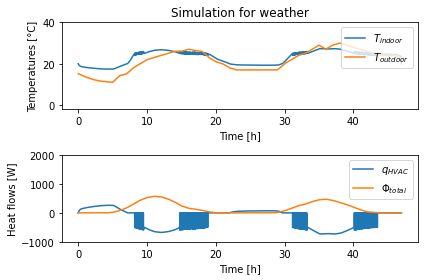

In [11]:
Kpp = 1e2   # perfect controller Kpc -> infinity
dt = 36     # time step, s
sim_HVAC()

> Figure 4. Simulation of a feedback P-controller implemented in input by using small timestep.

If the proportional gain is small, the precision is also small.

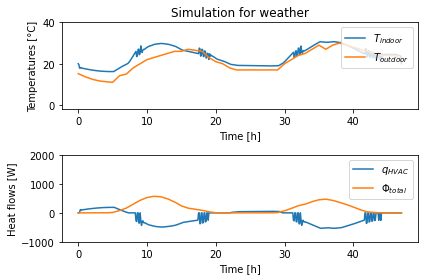

In [12]:
Kpp = 0.5e2   # perfect controller Kpc -> infinity
dt = 360     # time step, s
sim_HVAC()

> Figure 5. Simulation of a feedback P-controller with a small gain implemented in input.

If the porportional gain `Kpp` and the timestep `dt` are large, then the response is unstable. 

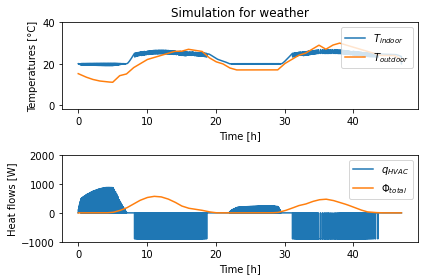

In [13]:
Kpp = 1e3   # perfect controller Kpc -> infinity
dt = 36
sim_HVAC()

> Figure 6. Simulation with large gain and large timestep.

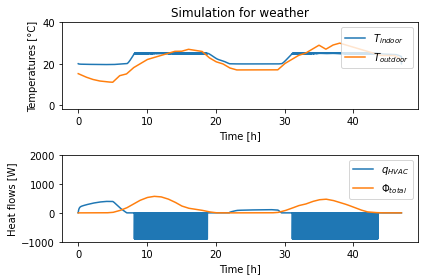

In [14]:
Kpp = 1e3   # perfect controller Kpc -> infinity
dt = 3.6
sim_HVAC()

> Figure 7. Simulation with large gain and small timestep.

## Simulation for different periods of the year

Let's use a large gain for the controller and a small timestep.

In [15]:
Kpp = 1e3   # perfect controller Kpc -> infinity
dt = 30

Let's simulate the system in different periods of the year.

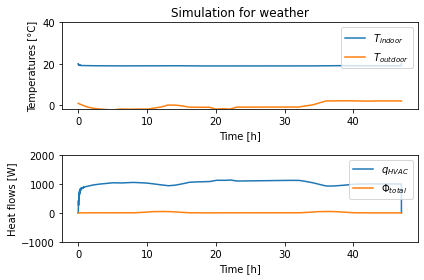

In [16]:
start_date = '2000-01-01 00:00:00'
end_date = '2000-01-03 00:00:00'
sim_HVAC()

> Figure 8. Simulation for heating period.

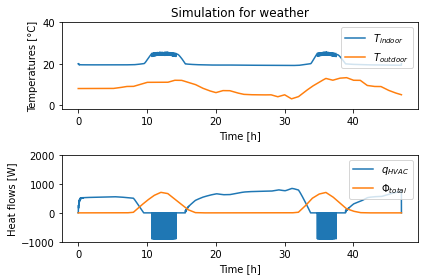

In [17]:
start_date = '2000-02-05 00:00:00'
end_date = '2000-02-07 00:00:00'
sim_HVAC()

> Figure 9. Simulation for heating with overheating.

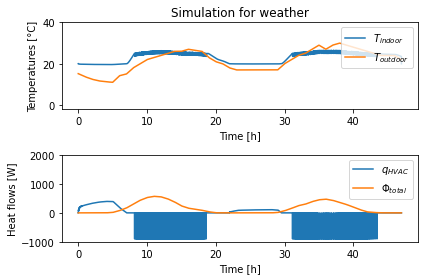

In [18]:
start_date = '2000-07-01 00:00:00'
end_date = '2000-07-03 00:00:00'
sim_HVAC()

> Figure 10. Simulation for cooling period.

## Free-cooling and solar protection
Cooling load can be reduced by [free-cooling](https://en.m.wikipedia.org/wiki/Free_cooling) and solar protections (like [roller shutters](https://en.m.wikipedia.org/wiki/Roller_shutter) and [window shutters](https://en.m.wikipedia.org/wiki/Window_shutter)).

The control of the indoor air temeperature by using the free-cooling and solar protections can be implmented in the integration loop:
- if the indoor temperature is smaller than its setpoint, then the heating system is acting;
- if the indoor temperature is larger than its setpoint, then:
    * if the outdoor temperature is smaller than the indoor setpoint, then use ventilation for free cooling;
    * else, reduce the solar radiation by closing the sutters.

In [19]:
def sim_sun_vent():
    l = 3                       # m length of the cubic room
    Va = l**3                   # m³ volume of air
    ACH = 1                     # air changes per hour
    Va_dot = ACH * Va / 3600    # m³/s air infiltration
    c = 1012                    # J/kg.K air specific heat
    ρ = 1.2                     # kg/m3 air density

    t, u, data = tuto.inputs(filename, start_date, end_date, dt,
                             As, Bs, Cs, Ds, Kpf, Tisp)

    θ = np.full([As.shape[0], u.shape[0]], np.inf)
    θ[:, 0] = Tisp * np.ones(As.shape[0])

    y = np.zeros(u.shape[0])
    y[-1] = Tisp

    for k in range(u.shape[0] - 1):
        if y[k - 1] < Tisp:             # heating
            u.iloc[k, 6] = Kpp * (Tisp - y[k - 1])
        elif y[k - 1] > Tisp + Δθ:      # cooling
            if data['To'][k] < Tisp:    # - by ventilation
                u.iloc[k, 6] = 10 * Va_dot * ρ * c * (data['To'][k] - y[k - 1])
            else:                       # - by solar protection
                u.iloc[k, 4] = u.iloc[k, 4] / 10
                u.iloc[k, 5] = u.iloc[k, 6] / 10
        else:
            u.iloc[k, 6] = 0

        θ[:, k + 1] = (I + dt * As) @ θ[:, k]\
            + dt * Bs @ u.iloc[k, :]

        # θ[:, k + 1] = np.linalg.inv(I - dt * As) @\
        #     (θ[:, k] + dt * Bs @ u.iloc[k, :])
        y[k] = Cs @ θ[:, k] + Ds @ u.iloc[k]

    q_HVAC = u.iloc[:, 6].to_numpy()

    tuto.plot_results(t, y, θ, q_HVAC, data)

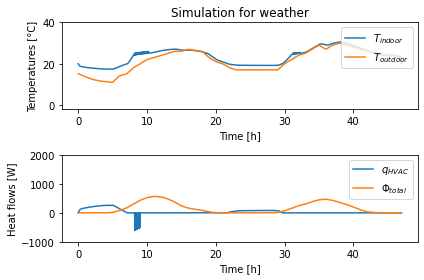

In [20]:
start_date = '2000-07-01 00:00:00'
end_date = '2000-07-03 00:00:00'
Kpp = 1e2   # perfect controller Kpc -> infinity
dt = 30     # time step, s
sim_sun_vent()

> Figure 11. Cooling mainly by solar protections. Note: there is free cooling when $q_{HVAC} < 0$.

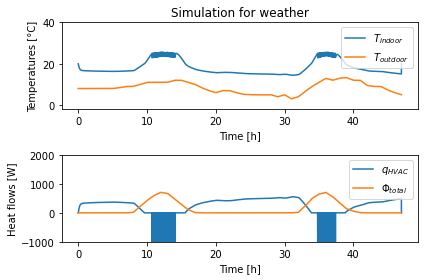

In [21]:
start_date = '2000-02-05 00:00:00'
end_date = '2000-02-07 00:00:00'
Kpp = 1e2   # perfect controller Kpc -> infinity
dt = 30     # time step, s
sim_sun_vent()

> Figure 12. Cooling by ventilation. Note: there is free cooling when $q_{HVAC} < 0$.